<a href="https://colab.research.google.com/github/gacerioni/redisvl_gabs_facial_recognition/blob/main/final_colab_redisvl_gabs_sunday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RedisVL Face Recognition Demo

In [1]:
# Install Redis and dependencies
!sudo apt-get install lsb-release curl gpg
!curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
!sudo chmod 644 /usr/share/keyrings/redis-archive-keyring.gpg
!echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
!sudo apt-get update
!sudo apt-get install redis-stack-server

# Start Redis in the background
!redis-stack-server --daemonize yes

# Verify Redis is running
!redis-cli ping

# Check Redis modules
!redis-cli INFO | grep -A 10 -i "modules"

# Verify Redis data directory
!redis-cli CONFIG GET dir

# Download the RDB snapshot
!wget -O /content/dump.rdb https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/dump.rdb

# Stop Redis to replace dump.rdb
!redis-cli shutdown save

# Move the downloaded RDB file
!sudo mv /content/dump.rdb /var/lib/redis-stack/dump.rdb
!sudo chmod 644 /var/lib/redis-stack/dump.rdb

# Restart Redis
!redis-stack-server --daemonize yes

# Wait for Redis to finish loading
import time
time.sleep(10)  # Adjust time as needed based on RDB size

# Verify the data
!redis-cli ping
!redis-cli dbsize

# List some keys
!redis-cli keys '*'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lsb-release is already the newest version (11.1.0ubuntu4).
lsb-release set to manually installed.
curl is already the newest version (7.81.0-1ubuntu1.19).
gpg is already the newest version (2.2.27-3ubuntu2.1).
gpg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://packages.redis.io/deb jammy InRelease [3,821 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-upd

21:24:19 redisvl.index.index INFO   Index already exists, overwriting.
Redis already contains 259 records. Skipping data injection.

--- Testing: Angelina Jolie ---

Match found: angelina_jolie, Distance: 0.27


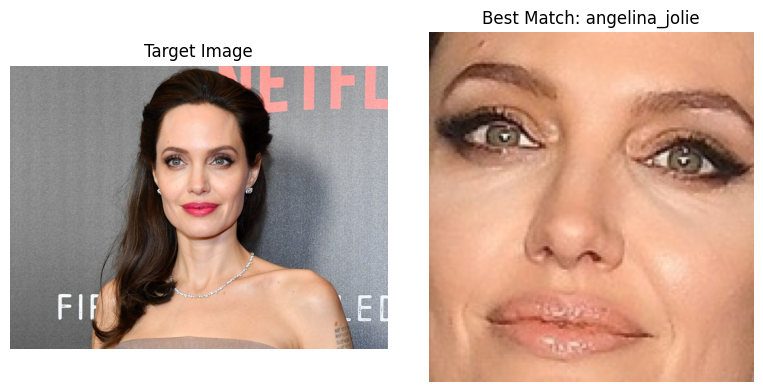


--- Testing: Kristen Stewart ---

No match found. Closest match is kristen_stewart (Distance: 0.45).


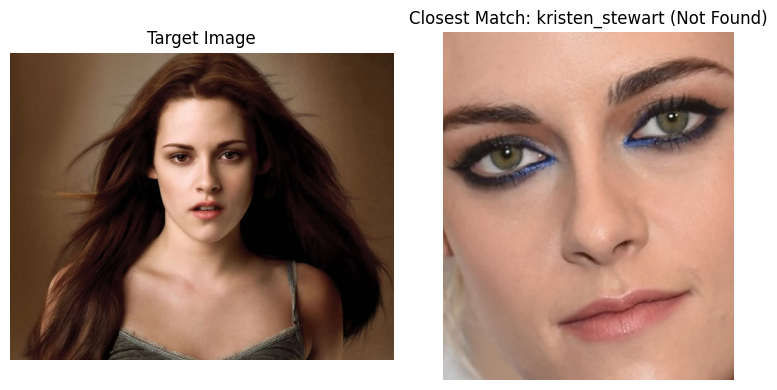


--- Testing: Hermione Granger ---

No match found. Closest match is emma_watson (Distance: 0.54).


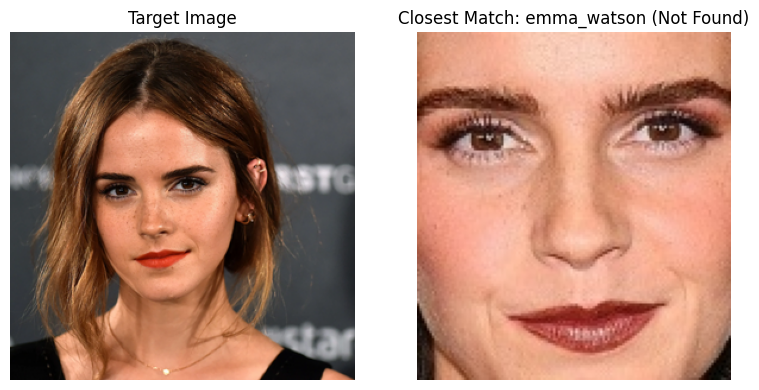


--- Testing: Gabriel Cerioni ---

Match found - but above VSS threshold: Shia LaBeouf, Distance: 0.55


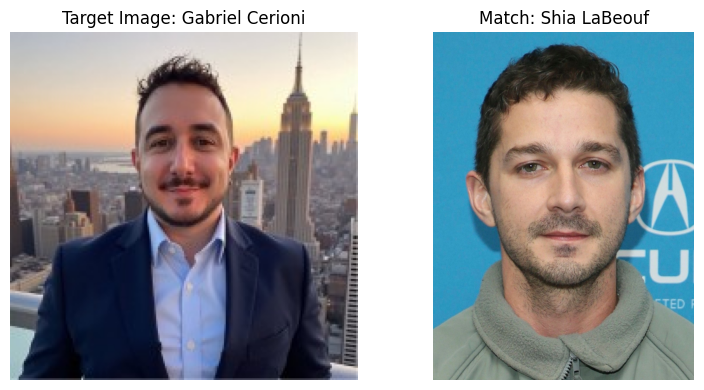

In [6]:
# Install Python dependencies
!pip install numpy pillow redis redisvl requests deepface -q

# Required imports
import os
import requests
import base64
import numpy as np
from PIL import Image, UnidentifiedImageError
from redisvl.index import SearchIndex
from redis import Redis
from urllib.parse import urlparse
from deepface import DeepFace
import matplotlib.pyplot as plt
from io import BytesIO
from zipfile import ZipFile

# Global variables
REDIS_URL = "redis://localhost:6379"
SAFE_THRESHOLD = 0.4
DATASET_URL = "https://redisvl-faces-dataset.s3.us-east-1.amazonaws.com/kaggle_famous_people_dataset.zip"
DATASET_PATH = "kaggle_famous_people_dataset"

# Download and extract dataset
if not os.path.exists(DATASET_PATH):
    print("Downloading dataset...")
    response = requests.get(DATASET_URL)
    with open("dataset.zip", "wb") as f:
        f.write(response.content)
    print("Extracting dataset...")
    with ZipFile("dataset.zip", "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove("dataset.zip")
    print("Dataset ready.")

# Functions
def get_redis_connection(redis_url):
    """Create a Redis connection from a URL."""
    parsed_url = urlparse(redis_url)
    return Redis(
        host=parsed_url.hostname,
        port=parsed_url.port or 6379,
        password=parsed_url.password,
        decode_responses=False  # Binary storage enabled
    )

def create_redis_index(client):
    """Define and create the Redis index."""
    schema = {
        "index": {
            "name": "face_recognition",
            "prefix": "face_docs",
        },
        "fields": [
            {"name": "name", "type": "tag"},
            {"name": "photo_reference", "type": "text"},
            {"name": "photo_binary", "type": "text"},
            {
                "name": "embedding",
                "type": "vector",
                "attrs": {
                    "dims": 128,
                    "distance_metric": "cosine",
                    "algorithm": "flat",
                    "datatype": "float32",
                }
            }
        ]
    }
    index = SearchIndex.from_dict(schema)
    index.set_client(client)
    index.create(overwrite=True)
    return index

def load_remote_image(url):
    """Download and return an image from a URL."""
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content))

def generate_embedding(image_path):
    """Generate an embedding for the image."""
    try:
        embedding = DeepFace.represent(image_path, model_name="Facenet")
        return np.array(embedding[0]["embedding"], dtype=np.float32)
    except Exception as e:
        print(f"Error generating embedding for {image_path}: {e}")
        return None

def inject_local_data_into_redis(base_path, index):
    """
    Loop through folders, grab one image per folder,
    generate embeddings, and store them in Redis.
    """
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if not os.path.isdir(folder_path):
            continue  # Skip files, process only directories

        jpeg_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".jpeg")]
        if not jpeg_files:
            print(f"No JPEGs found in folder: {folder_path}")
            continue

        for jpeg_file in jpeg_files:
            image_path = os.path.join(folder_path, jpeg_file)
            try:
                # Load image and convert to Base64
                with open(image_path, "rb") as img_file:
                    encoded_binary = base64.b64encode(img_file.read()).decode("utf-8")

                # Generate embedding
                embedding = generate_embedding(image_path)
                if embedding is None:
                    continue

                # Store data in Redis
                index.load([{
                    "name": folder_name,
                    "photo_reference": image_path,
                    "photo_binary": encoded_binary,
                    "embedding": embedding.tobytes()
                }])
                print(f"Stored {folder_name} in Redis with image: {jpeg_file}")
                break  # Successfully processed this folder
            except (UnidentifiedImageError, IOError) as e:
                print(f"Error processing image {image_path}: {e}")
                continue

def display_images_side_by_side(images, titles, figsize=(8, 4)):
    """Display a list of images side by side."""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    for ax, img, title in zip(axes, images, titles):
        # Convert images to RGB to prevent ghost/negative colors
        img = img.convert("RGB")
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(title, fontsize=12)
    plt.tight_layout()
    plt.show()

def query_redis(target_image_path, index, client, threshold=SAFE_THRESHOLD):
    """Query Redis and display visual results."""
    # Generate embedding for the target image
    target_embedding = generate_embedding(target_image_path)
    if target_embedding is None:
        print(f"Failed to generate embedding for {target_image_path}")
        return

    # Query Redis
    from redisvl.query import VectorQuery
    query = VectorQuery(
        vector=target_embedding.tolist(),
        vector_field_name="embedding",
        return_fields=["name", "photo_reference", "vector_distance", "photo_binary"],
        num_results=1  # Only need the best match
    )
    results = index.query(query)

    if not results:
        print("No matches found in Redis.")
        return

    # Parse the best match
    best_match = results[0]
    match_name = best_match["name"]
    match_distance = float(best_match["vector_distance"])
    match_image = Image.open(BytesIO(base64.b64decode(best_match["photo_binary"]))).convert("RGB")

    # Load the target image and ensure RGB mode
    target_image = load_remote_image(target_image_path).convert("RGB")

    # Display results
    if match_distance > threshold:
        print(f"\nNo match found. Closest match is {match_name} (Distance: {match_distance:.2f}).")
        display_images_side_by_side(
            [target_image, match_image],
            ["Target Image", f"Closest Match: {match_name} (Not Found)"]
        )
    else:
        print(f"\nMatch found: {match_name}, Distance: {match_distance:.2f}")
        display_images_side_by_side(
            [target_image, match_image],
            ["Target Image", f"Best Match: {match_name}"]
        )

def clear_face_docs(client):
    """Delete all face_docs:* entries in Redis."""
    keys = client.keys("face_docs:*")
    if keys:
        client.delete(*keys)
        print(f"Deleted {len(keys)} keys matching 'face_docs:*'.")
    else:
        print("No keys matching 'face_docs:*' found.")

def fake_query_simulation():
    """Simulate a fake query result."""
    target_url = "https://media.licdn.com/dms/image/v2/D4D03AQHDsUQMB5duYw/profile-displayphoto-shrink_200_200/profile-displayphoto-shrink_200_200/0/1729695059139?e=2147483647&v=beta&t=X2EWD5-I5_9lbnoAh3XnW7cqa0tZQawkVihilpLgEoY"
    fake_match_url = "https://resizing.flixster.com/-XZAfHZM39UwaGJIFWKAE8fS0ak=/v3/t/assets/189825_v9_bc.jpg"
    fake_match_label = "Shia LaBeouf"

    # Load the images
    target_image = load_remote_image(target_url).convert("RGB")
    fake_match_image = load_remote_image(fake_match_url).convert("RGB")

    # Print fake match results
    print("--- Testing: Gabriel Cerioni ---")
    print(f"\nMatch found - but above VSS threshold: {fake_match_label}, Distance: 0.55")
    display_images_side_by_side(
        [target_image, fake_match_image],
        ["Target Image: Gabriel Cerioni", f"Match: {fake_match_label}"]
    )

def main():
    """Main function to run face recognition demo."""
    # Connect to Redis
    client = get_redis_connection(REDIS_URL)

    # Ensure the Redisvl index is valid
    index = create_redis_index(client)

    # Check if Redis already contains data
    existing_data_count = int(client.dbsize())
    if existing_data_count > 0:
        print(f"Redis already contains {existing_data_count} records. Skipping data injection.")
    else:
        # Inject data into Redis from Kaggle dataset if no data is present
        dataset_path = "kaggle_famous_people_dataset"
        inject_local_data_into_redis(dataset_path, index)
        print("Data successfully injected into Redis.")

    # Test queries
    test_cases = [
        ("https://github.com/serengil/deepface/raw/master/tests/dataset/img2.jpg", "Angelina Jolie"),
        ("https://hellogiggles.com/wp-content/uploads/sites/7/2016/11/11/4202612-kristen-stewart-2009-twilight-new-moon-normal5.4.jpg?quality=82&strip=all", "Kristen Stewart"),
        ("https://static.wikia.nocookie.net/littlewomen/images/a/ac/Emmawatson.png/revision/latest?cb=20191221175400", "Hermione Granger"),
        # ("https://hairstyles.thehairstyler.com/hairstyle_views/front_view_images/3920/original/Daniel-Radcliffe.jpg", "Daniel Radcliffe"),
        # ("https://i.pinimg.com/236x/86/1e/cd/861ecdea00e123427268231fbc164a44.jpg", "Adam Sandler"),
        # ("https://github.com/serengil/deepface/raw/master/tests/dataset/img42.jpg", "Zooey Deschanel (Expect Katy Perry Test)"),
        # ("https://media.licdn.com/dms/image/v2/D4D03AQHDsUQMB5duYw/profile-displayphoto-shrink_200_200/profile-displayphoto-shrink_200_200/0/1729695059139?e=2147483647&v=beta&t=X2EWD5-I5_9lbnoAh3XnW7cqa0tZQawkVihilpLgEoY", "Gabriel Cerioni"),
        # ("https://resizing.flixster.com/-XZAfHZM39UwaGJIFWKAE8fS0ak=/v3/t/assets/189825_v9_bc.jpg", "Shia Labeouf")
    ]

    for image_url, label in test_cases:
        print(f"\n--- Testing: {label} ---")
        query_redis(image_url, index, client)

    print("")
    fake_query_simulation()



if __name__ == "__main__":
    main()